In [1]:
# Running on Colab
!pip install andi-datasets==0.0.5
!pip install fbm==0.3.0
!git clone --depth 1 https://github.com/tsmbland/andi_challenge.git
import sys
sys.path.append('andi_challenge')
from andi_funcs import package_tracks
import andi
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(3) 

# # Running locally
# import sys
# sys.path.append('..')
# from andi_funcs import package_tracks
# import andi
# import matplotlib.pyplot as plt
# import numpy as np
# %matplotlib notebook
# np.random.seed(3) 

## Generating and preprocessing tracks for CNN input

This notebook will outline the procedures used in this study to generate simulated tracks and prepare them for input to convolutional neural networks. 

### Generate tracks

We can use the handy [andi_datasets](https://github.com/AnDiChallenge/ANDI_datasets) package to generate simulated trajectories. Please follow the link for instructions on using this package.

The following code will simulate 10 1D tracks between 50 and 100 steps in length (these will be a mix of diffusion models):

In [2]:
AD = andi.andi_datasets()
X1, Y1, X2, Y2, X3, Y3 = AD.andi_dataset(N=5, min_T=50, max_T=101, tasks=[1], dimensions=[1]);

exponents = Y1[0]
tracks = X1[0]

Creating a dataset for task(s) [1] and dimension(s) [1].
Generating dataset for dimension 1.


/Users/blandt/anaconda3/anaconda3/envs/andi_challenge/lib/python3.7/site-packages/andi/diffusion_models.py:65: RuntimeWarning: invalid value encountered in reciprocal
  times = np.cumsum((1-np.random.rand(T))**(-1/alpha))
/Users/blandt/anaconda3/anaconda3/envs/andi_challenge/lib/python3.7/site-packages/fbm/fbm.py:172: UserWarning: Combination of increments n and Hurst value H invalid for Davies-Harte method. Reverting to Hosking method. Occurs when n is small and Hurst is close to 1. 
  "Combination of increments n and Hurst value H "


<IPython.core.display.Javascript object>


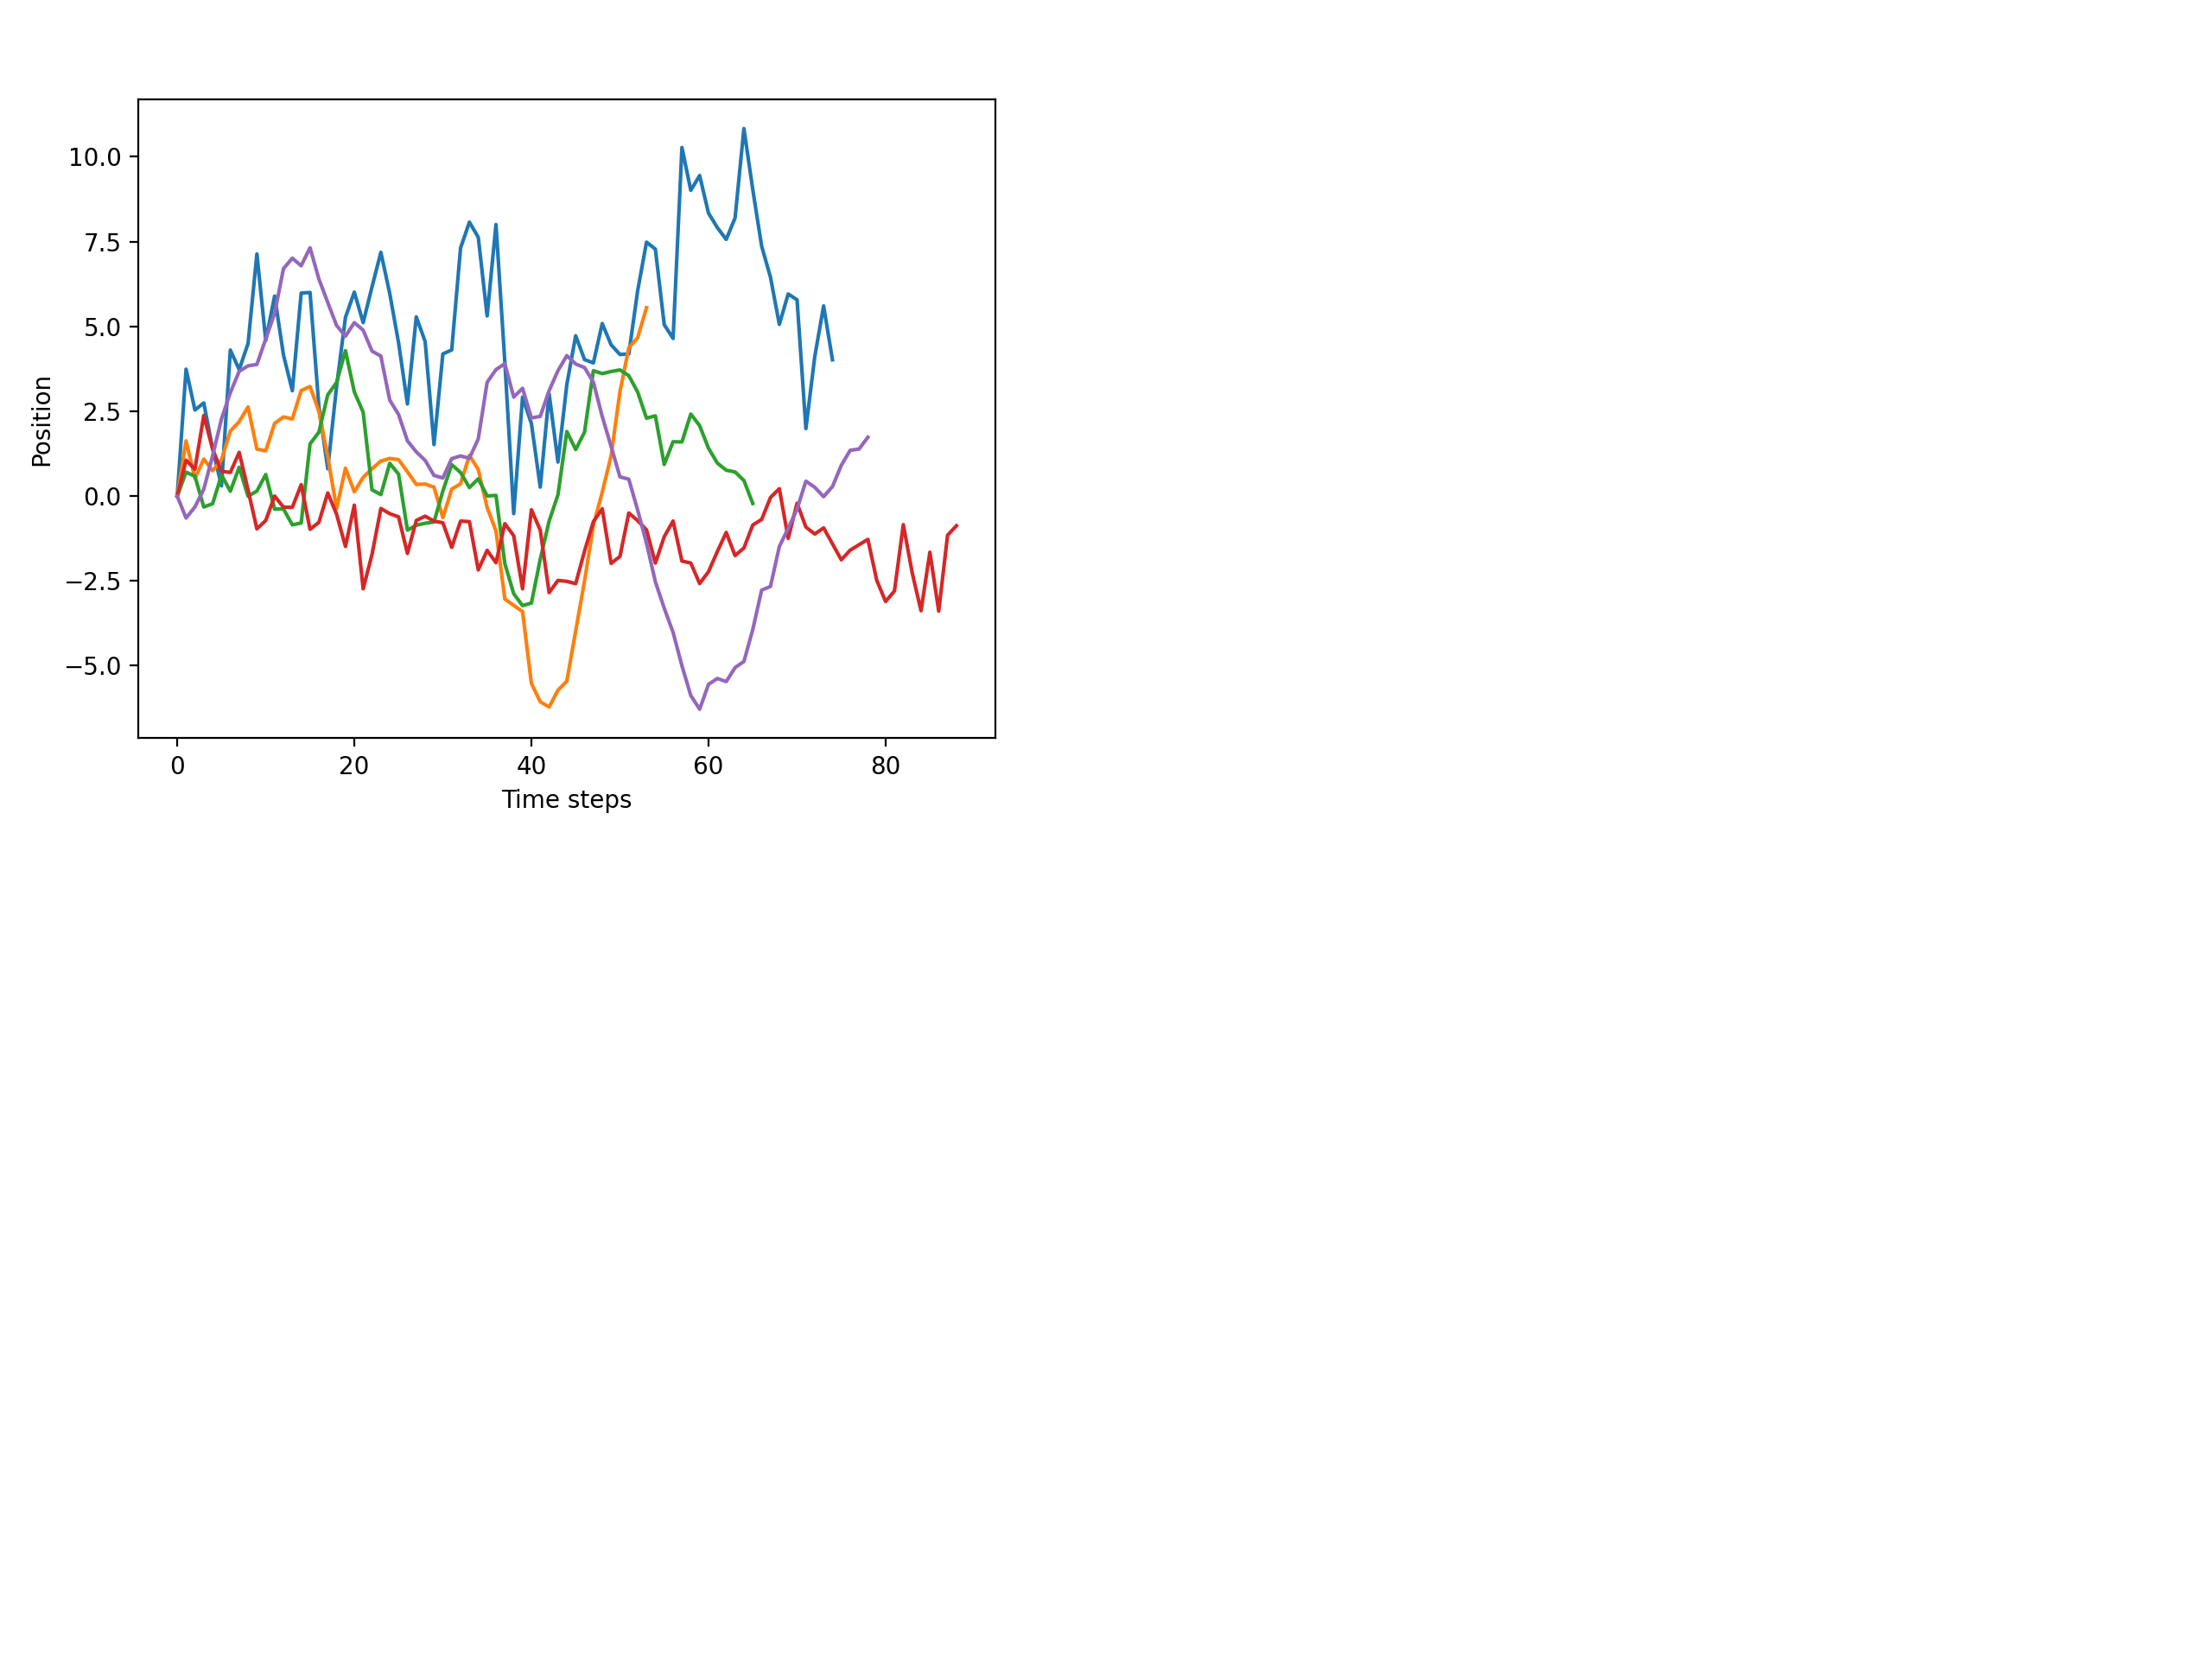

In [3]:
fig, ax = plt.subplots()
for t in tracks:
    ax.plot(t)
ax.set_xlabel('Time steps')
ax.set_ylabel('Position');

### Preprocess tracks

We need to process these tracks before they are suitable for inputting into a neural network. This can be done in a few different ways. In this study I performed the following 4 operations:

#### Step 1. Take differences

Taking the differences between successive time points, i.e. converting data from position to step size. This is easier for a machine learning model to learn from as values are smaller and independent of track length (position values can get very large for long tracks).

<IPython.core.display.Javascript object>


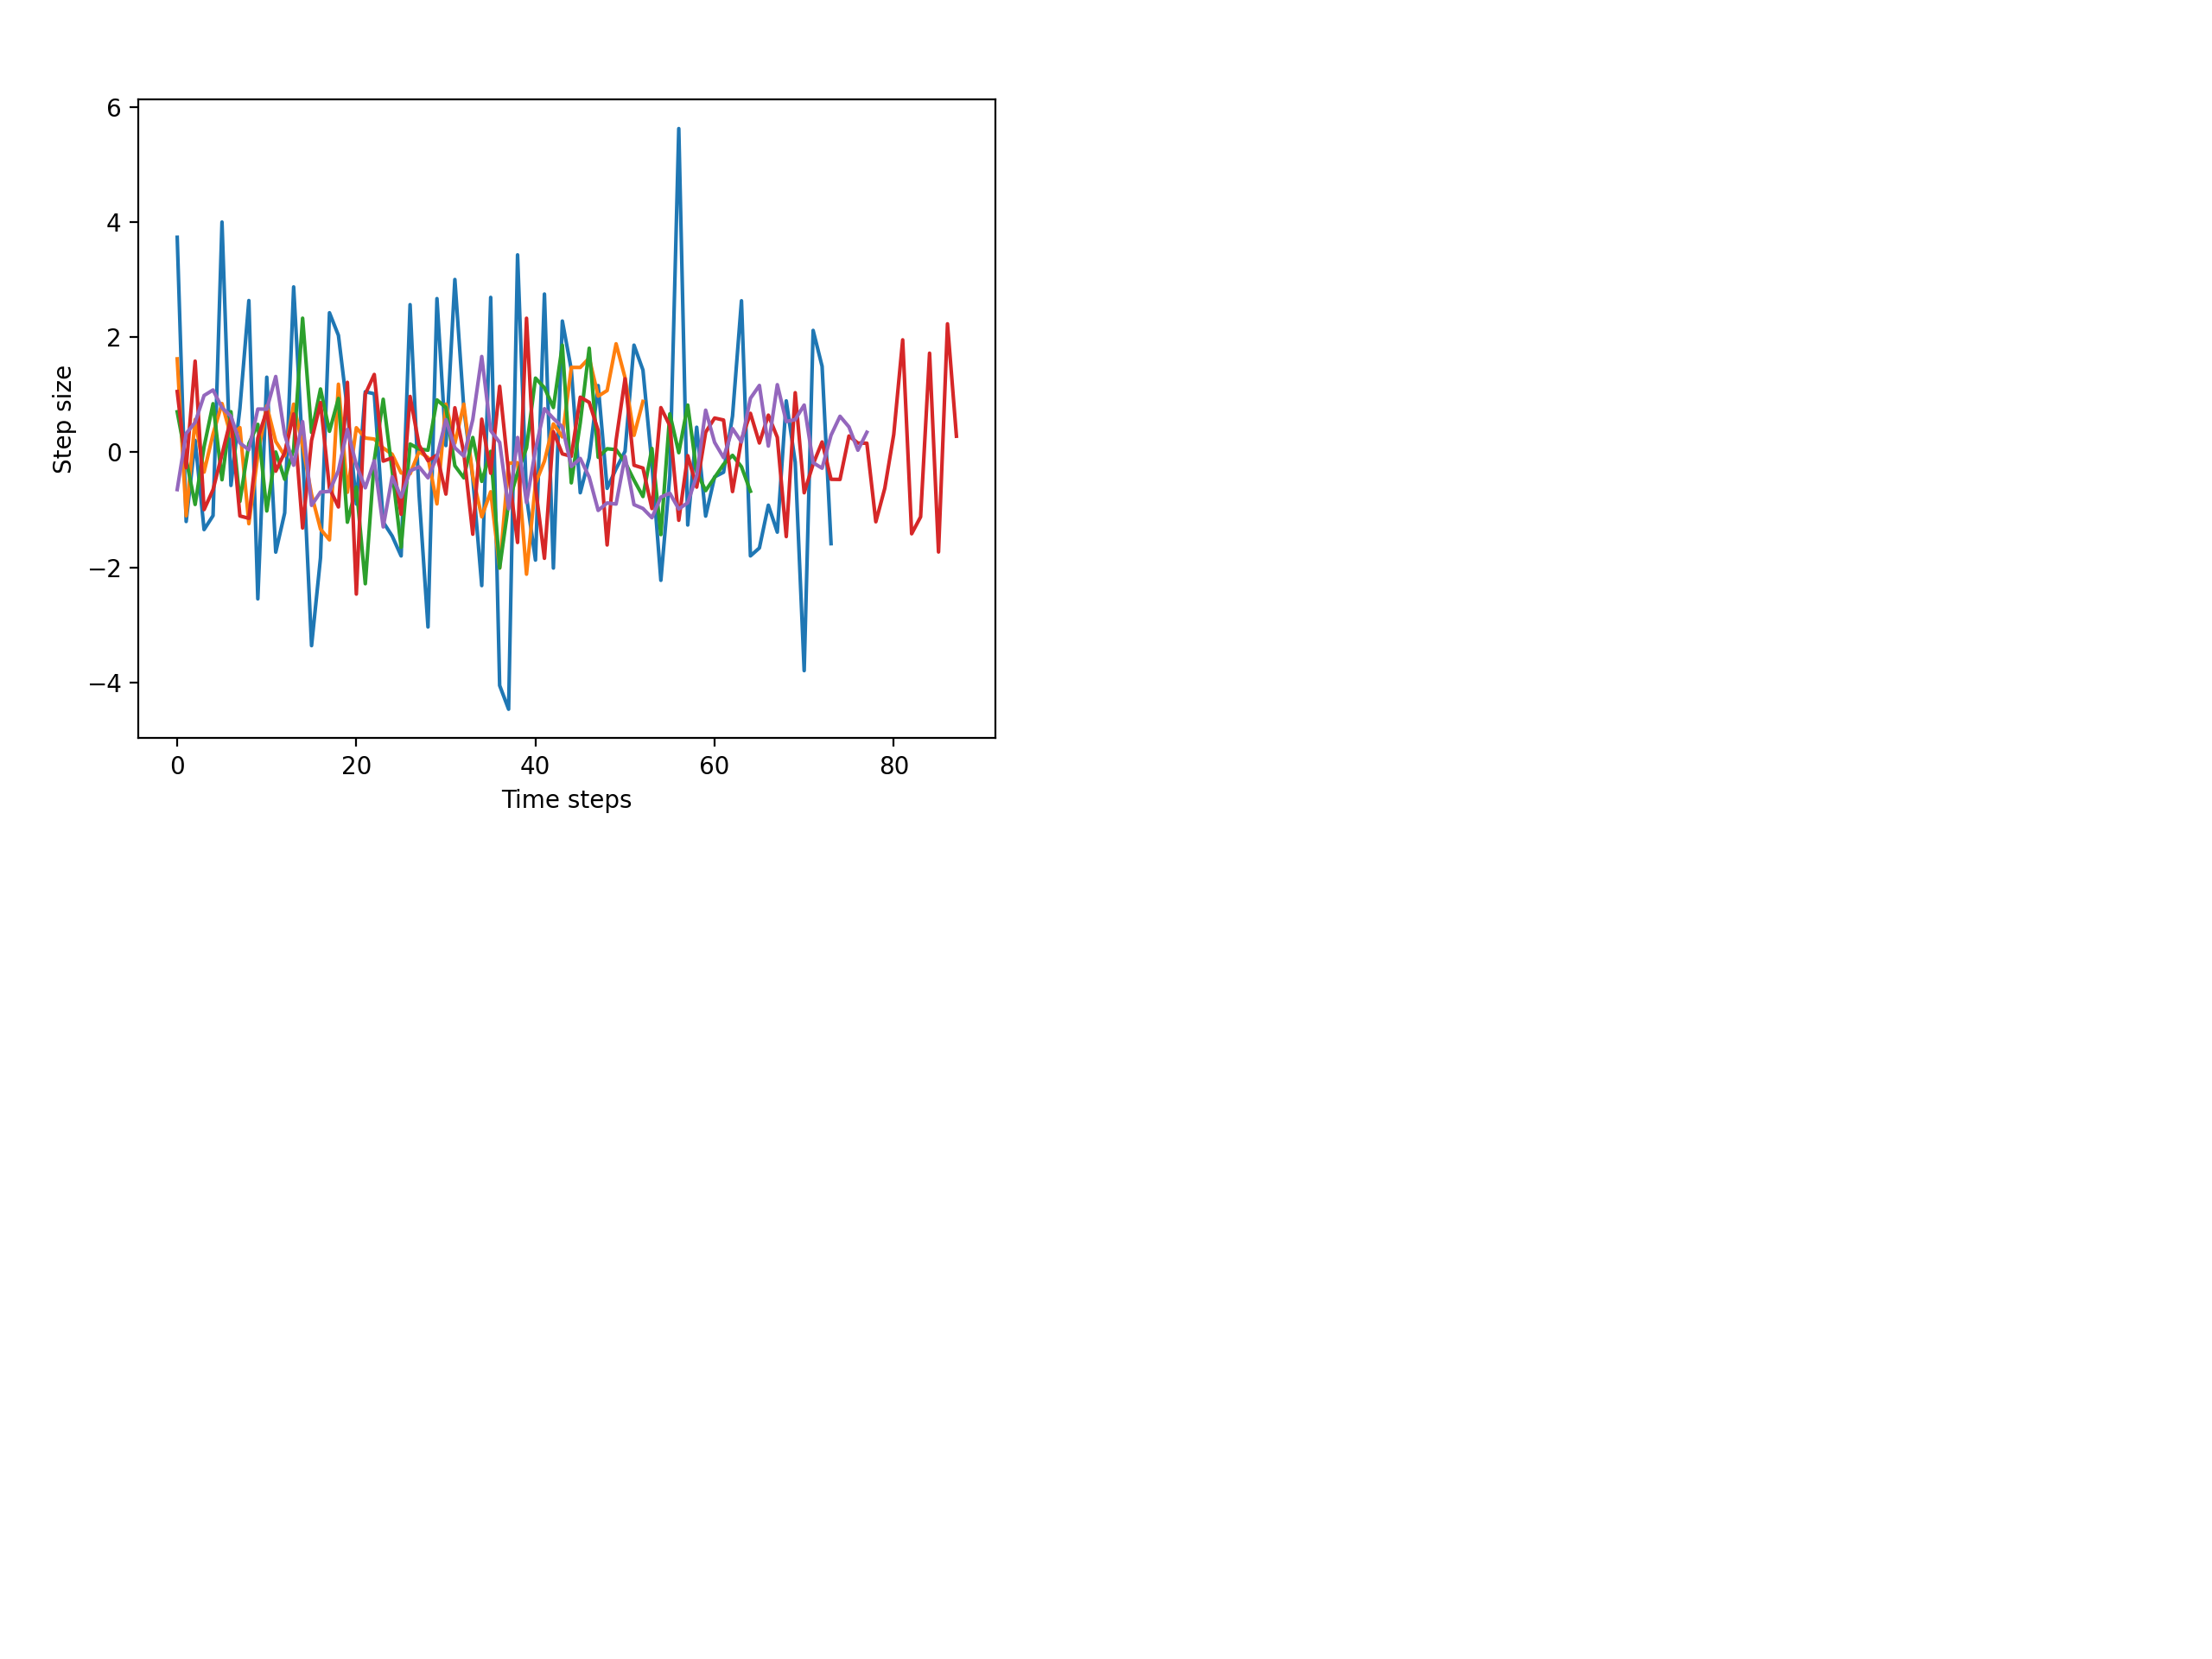

In [4]:
fig, ax = plt.subplots()
tracks_diff = []
for t in tracks:
    t_diff = np.diff(t)
    ax.plot(t_diff)
    tracks_diff.append(t_diff)
ax.set_xlabel('Time steps')
ax.set_ylabel('Step size');

#### Step 2. Normalise by mean step size

Dividing step size values by the mean absolute value for the entire trajectory. This scales values for different tracks onto roughly the same order, regardless of the underlying diffusion coefficient.

<IPython.core.display.Javascript object>


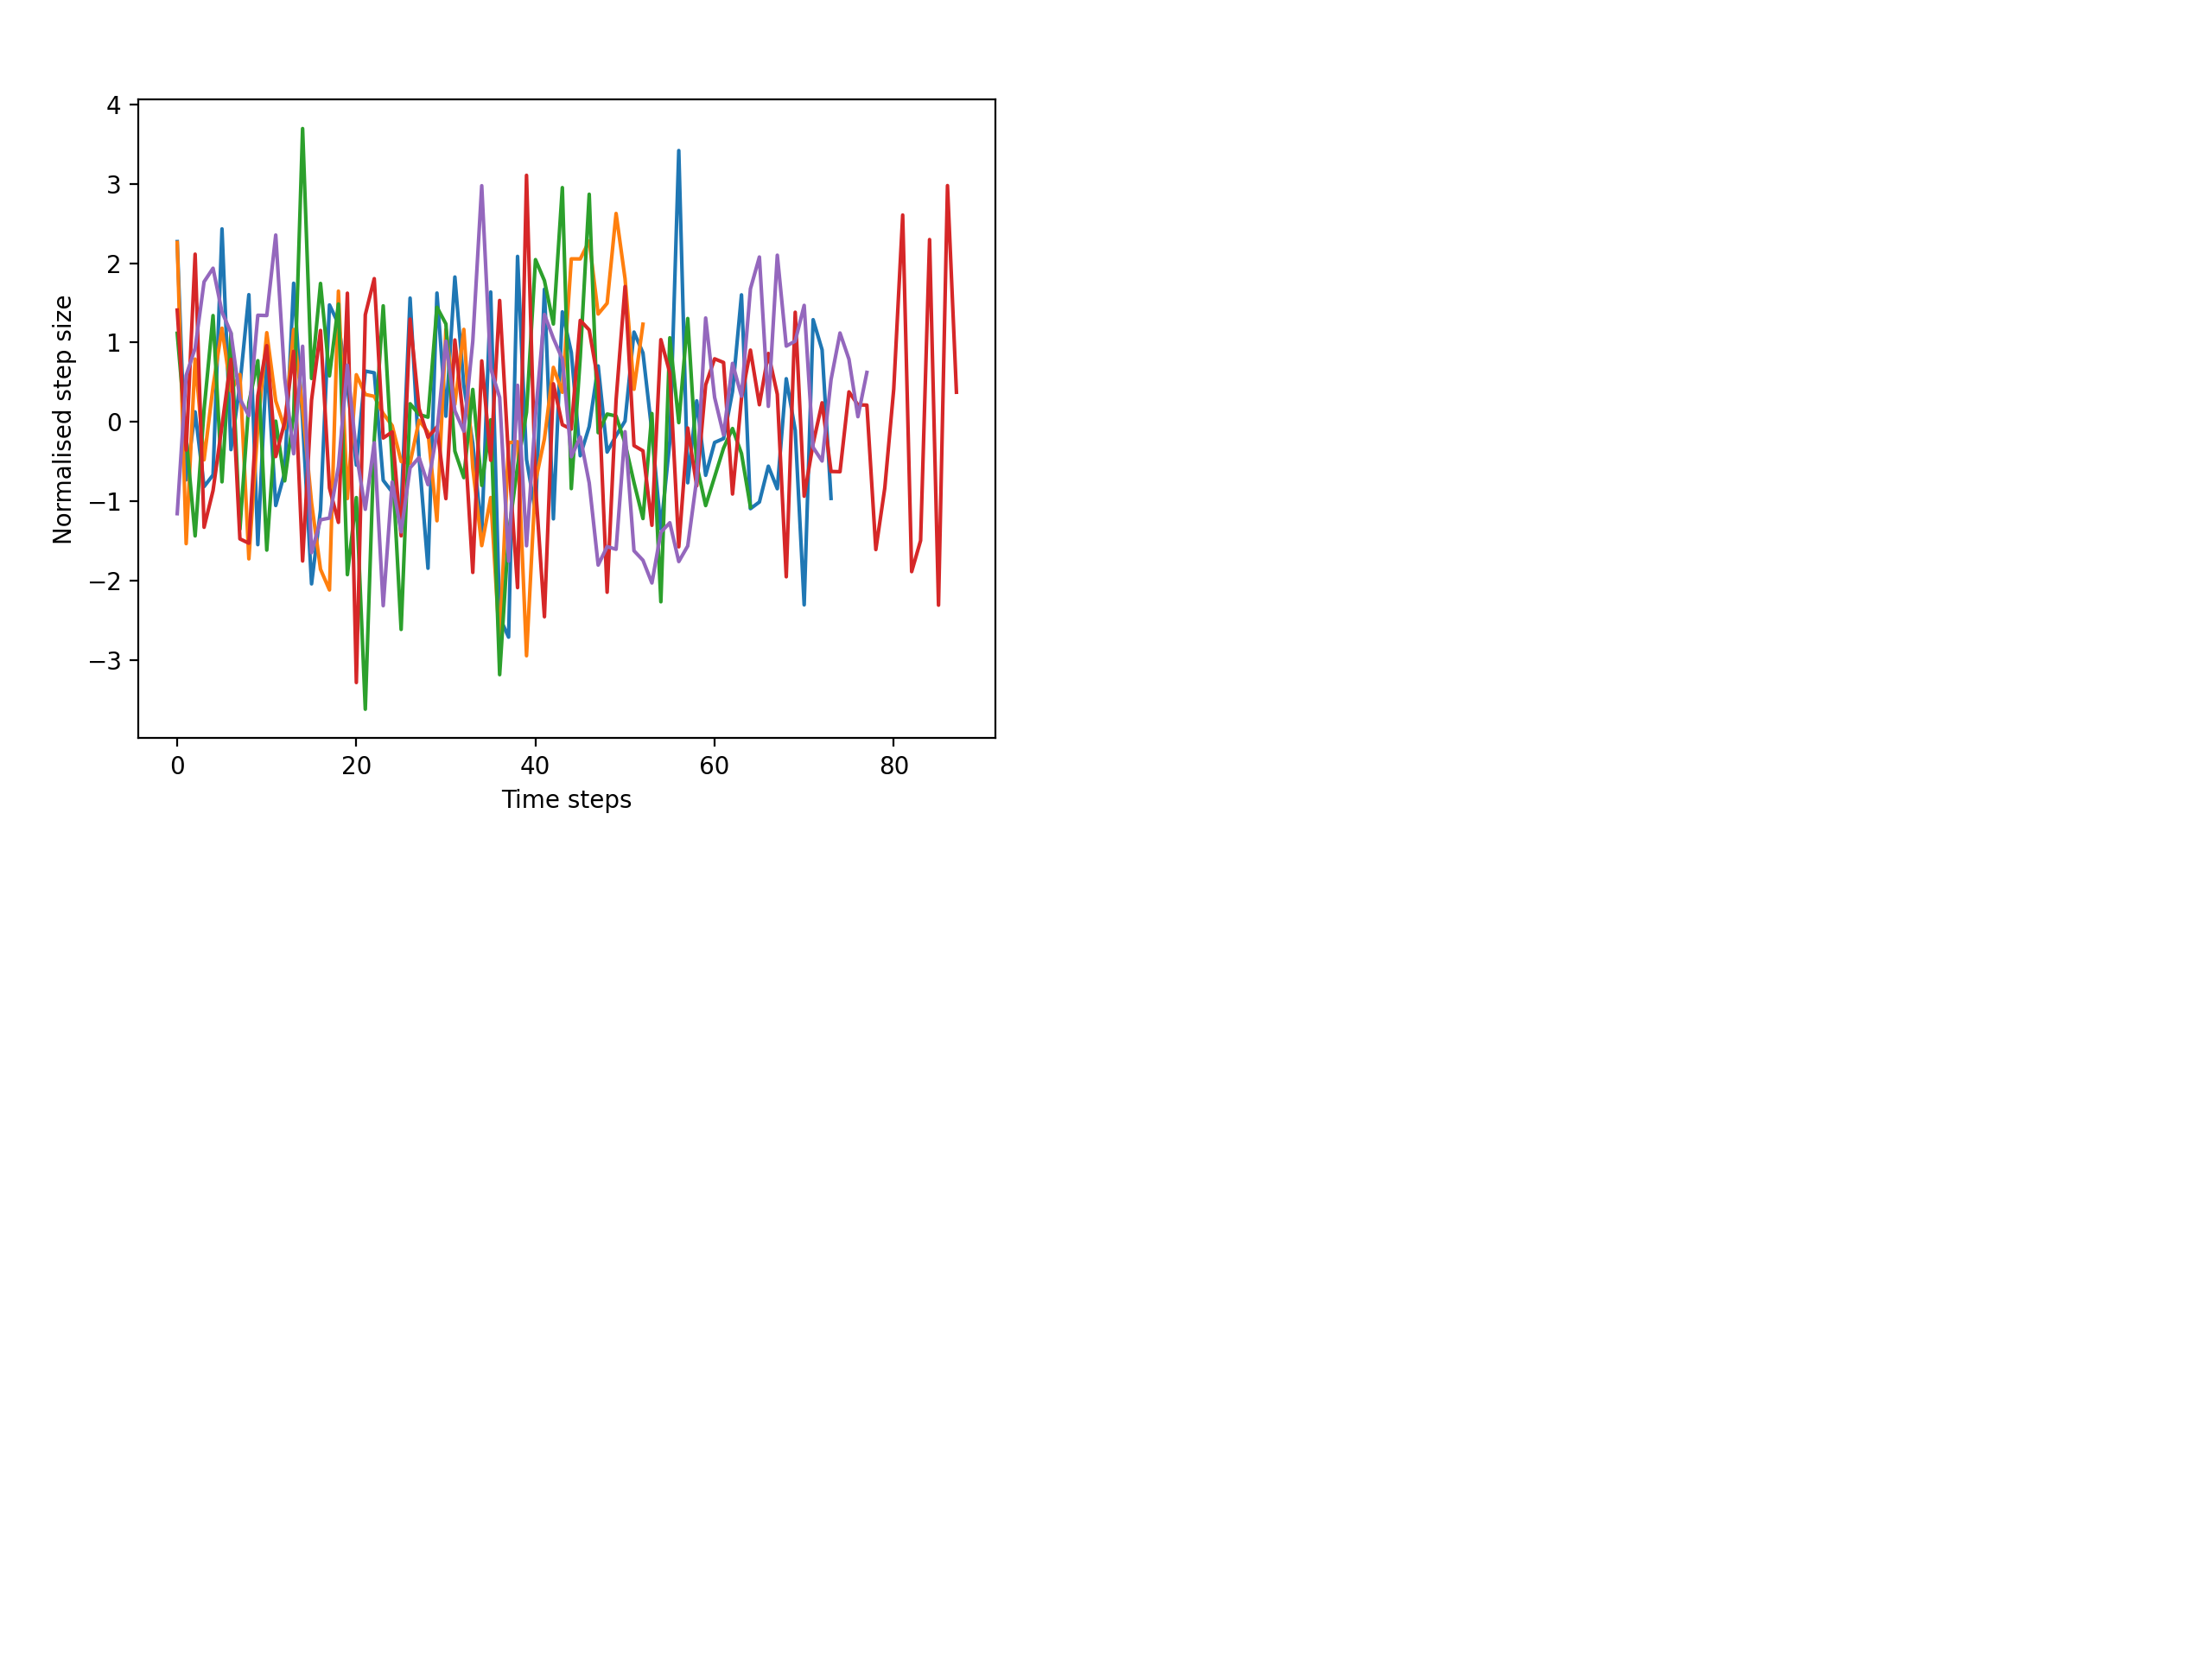

In [5]:
fig, ax = plt.subplots()
tracks_diff_norm = []
for t_diff in tracks_diff:
    mean_step = np.mean(abs(t_diff))
    t_diff_norm = t_diff / mean_step
    ax.plot(t_diff_norm)
    tracks_diff_norm.append(t_diff_norm)
ax.set_xlabel('Time steps')
ax.set_ylabel('Normalised step size');

#### Step 3. Pad tracks to a uniform length

The CNNs need to take track data in batches in the form of an array. This requires the input data for all tracks in the batch to be the same length. To do this we can simply prepend zeros to the start of each track to get them up to the same size.

Note that whilst these 0's will lead to some computing power being devoted to 0x0 calculations during CNN training, these zeros will ultimately be ignored in the max pooling part of the network and have no bearing on the final output. During inference it's perfectly acceptable to ignore this step and run through individual tracks without padding, but it will often still be quicker to pad tracks and run them through in batches.

<IPython.core.display.Javascript object>


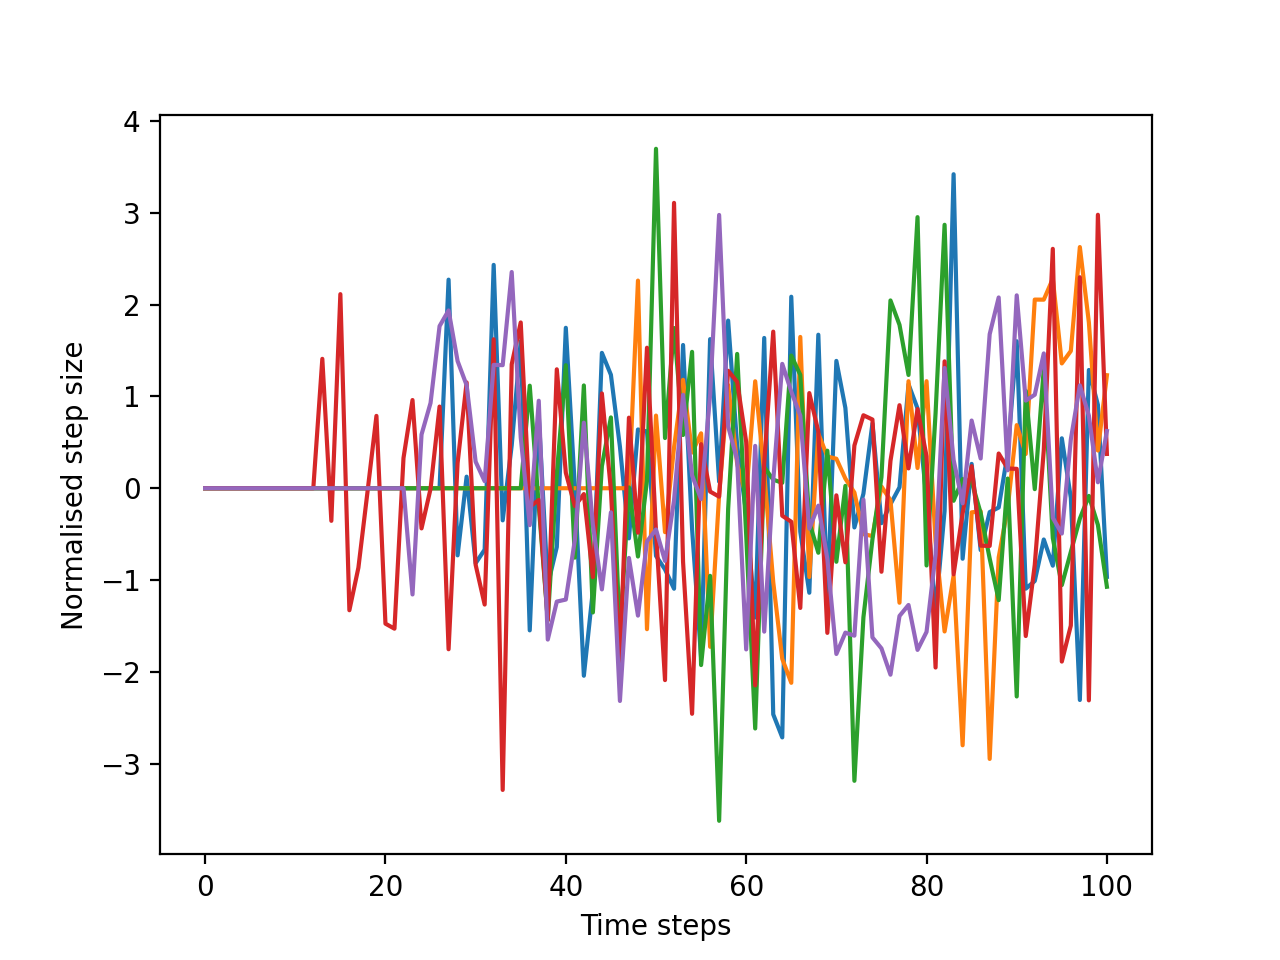

In [6]:
fig, ax = plt.subplots()
tracks_diff_norm_padded = []
max_T = 101
for t_diff_norm in tracks_diff_norm:
    t_length = len(t_diff_norm)
    t_diff_norm_padded = np.r_[np.zeros(max_T - t_length), t_diff_norm.flatten()]
    ax.plot(t_diff_norm_padded)
    tracks_diff_norm_padded.append(t_diff_norm_padded)  
ax.set_xlabel('Time steps')
ax.set_ylabel('Normalised step size');

#### Step 4. Package into an array

The CNNs take numpy arrays of shape [N, max_T, n_dimensions].

In [7]:
cnn_input = np.expand_dims(np.array(tracks_diff_norm_padded), axis=-1)
print(cnn_input.shape)

(5, 101, 1)


## Summary

The package_tracks function in the andi_funcs file can be used to perform the above operations in a single line

In [8]:
cnn_input = package_tracks(tracks=tracks, max_T=101, dimensions=1)

In [9]:
print(cnn_input.shape)

(5, 100, 1)
